In [1]:
import pandas as pd
import xlrd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df1 = pd.read_excel('Northern Branch trackers/Northern Division 2021 Debris Removal Tracker.xlsx')
df2 = pd.read_csv("tetra forms ASB and SA/Asbestos Tracker.csv", parse_dates=True)

In [3]:
# we have to open the file then save it with a different name as an excel. Find a way to solve this
df3= pd.read_excel("tetra forms ASB and SA/ASB_TetraForms_survey1.xlsx")

In [4]:
# we have to open the file then save it with a different name as an excel. Find a way to solve this
# df3= pd.read_excel("ASB/ASB_TetraForms1.xlsx")

In [5]:
smartsheets = df1.copy()
asbestos = df2.copy()
tetratForms = df3.copy()

In [6]:
# tetratForms.info()

In [7]:
# asbestos.loc[asbestos['APN'] =='028-261-052',['APN','Chimney']]

# Most important info

What I Check Daily is Smart Sheets vs Tracker
* Chimneys and neshaps match
* FINAL RESULTS vs Smart sheets – biggest concern

* ASB Assessment Date Match

* End of day numbers match

In [8]:
# smartsheets.info()

# asbestos set up

In [9]:
# Take out all divisions other than central.
asbestos = asbestos[asbestos['Division'].isin(['Northern Division'])]

In [10]:
# changes date column from object to a date.
asbestos['Date Collected'] = pd.to_datetime(asbestos['Date Collected']).dt.date
asbestos['Chimney Tip Date'] = pd.to_datetime(asbestos['Chimney Tip Date']).dt.date
asbestos['Chimney Abatement Completed Date'] = pd.to_datetime(asbestos['Chimney Abatement Completed Date']).dt.date
asbestos['Asbestos Abatement Completed Date'] = pd.to_datetime(asbestos['Asbestos Abatement Completed Date']).dt.date

In [11]:
asbestos.columns = map(str.upper, asbestos.columns)

In [12]:
# Column section all upper case
asb_cols = asbestos[['APN', 'FINAL RESULTS', 'CHIMNEY', 'CHIMNEY TIP DATE', 'CHIMNEY FINDING',
                 'NESHAP WALLS',
                 'DATE COLLECTED', 
                 'SAMPLE QUANTITY', 'POINT COUNT NEEDED', 'POINT COUNT RESULTS',
                 'ASBESTOS ABATEMENT COMPLETED DATE', 'CHIMNEY ABATEMENT COMPLETED DATE',
                 'PLANNING NOTES', 'DIVISION']]

In [13]:
# # Column section normal
# test1 =asbestos[['APN','Final Results','Chimney','Chimney Tip Date','Chimney Finding',
#                  'NESHAP Walls', 
#                  'Date Collected',
#                  'Sample Quantity','Point Count Needed','Point Count Results',
#                  'Asbestos Abatement Completed Date','Chimney Abatement Completed Date',
#                  'Planning Notes','Division']]
# # test1.head(5)

# Tetra Forms setup

### sheet sample_log setup

In [14]:
TF = pd.read_excel("tetra forms ASB and SA/ASB_TetraForms_survey1.xlsx", sheet_name='sample_log')

In [15]:
max_samples = TF.groupby(['apn'])[['samplecounter']].max().reset_index()


## Tetra Forms chimney tip setup
Combine chimney tip database with sample log

In [16]:
TF_tips = pd.read_excel('tetra forms ASB and SA/ASB_TetraForms_tips1.xlsx')

In [17]:
# columns needed
TF_tips= TF_tips[['apn', 'inspection_date']]

In [18]:
# rename for easy reading for later merges
TF_tips.rename(columns={'inspection_date': 'TIP INSPECTION_TF'}, inplace=True)

In [19]:
# Need to make this series a datetime and fill in 0'sfor blank spots
TF_tips['TIP INSPECTION_TF'] = pd.to_datetime(TF_tips['TIP INSPECTION_TF']).dt.date.fillna(0)

In [20]:
merge1 = max_samples.merge(TF_tips,
                          left_on='apn',
                          right_on='apn',
                          how='outer')

# Tetra Forms Abatment date setup
Combine Abatment date database with merge 1 (tips and max samples)

In [21]:
# abatment clearance form logs
TF_abate = pd.read_excel('tetra forms ASB and SA/ASB_TetraForms_abatment1.xlsx')

In [22]:
# columns needed
TF_abate = TF_abate[['apn', 'abatement_end']]

In [23]:
# Need to make this series a datetime and fill in 0'sfor blank spots
TF_abate['abatement_end'] = pd.to_datetime(TF_abate['abatement_end']).dt.date.fillna(0)

In [24]:
# rename for easy reading on later merges
TF_abate.rename(columns={'abatement_end': 'ABATEMENT END_TF'}, inplace=True)

In [25]:
merge2 = merge1.merge(TF_abate,
                     left_on='apn',
                     right_on='apn',
                     how='outer')

# Master Tetra Forms setup from all thre databases
* Chimney tips
* abatement dates
* asbestos survey info

In [26]:
tetratForms = tetratForms.merge(merge2,
                 left_on='apn',
                 right_on='apn',
                 how='outer')

In [27]:
# columns needed
tetratForms = tetratForms[['apn', 'chimneys','walls','inspection_date', 'county','samplecounter','TIP INSPECTION_TF',
                           'ABATEMENT END_TF' ]]

In [28]:
# change date object to date time format
tetratForms['inspection_date'] = pd.to_datetime(tetratForms['inspection_date']).dt.date

In [29]:
# easier read for later merges
tetratForms.rename(columns={'inspection_date': 'survey inspection date'}, inplace=True)

In [30]:
# chossing couty for only northern division. Only way to seperate the divisions in Tetra forms
tetratForms = tetratForms[tetratForms['county'].isin(['LASSEN', 'PLUMAS', 'SISKIYOU', 'TRINITY'])]

In [31]:
# tetratForms.rename(columns={'walls': 'NESHAP Walls','inspection_date':'DATE COLLECTED'}, inplace=True)

In [32]:
# make ALL columnS upper CASE
tetratForms.columns =map(str.upper, tetratForms.columns)

In [33]:
# tetratForms.columns

# Smart Sheet set up

In [34]:
# changes date column from object to a date.and fill na with 0's
smartsheets["ASB Assessment"] = smartsheets["ASB Assessment"].dt.date.fillna(0)
smartsheets["Chimney Tipped"] = smartsheets["Chimney Tipped"].dt.date.fillna(0)
smartsheets["ASB Abatement"] = smartsheets["ASB Abatement"].dt.date.fillna(0)

In [35]:
smartsheets.rename(columns={'ASB Assessment': 'Date Collected', 'Chimney Tipped':'CHIMNEY TIP DATE',
                            'County': 'SS_COUNTY'}, inplace=True)

In [36]:
smartsheets.columns = map(str.upper, smartsheets.columns)

In [37]:
# Column section normal uppercase
ss_cols = smartsheets[['APN_ROW SEGMENT','STREET #','STREET NAME','STRUCTURAL STATUS','SS_COUNTY','ASB RESULTS',
                     'CHIMNEY','CHIMNEY TIP DATE',
                     'NESHAP WALLS', 
                     "DATE COLLECTED",
                     'ASB ABATEMENT']]

# merge mart sheets with ASB tracker

In [38]:
ASB_SS_Merge = ss_cols.merge(asb_cols,
           left_on='APN_ROW SEGMENT',
           right_on='APN',
           how='outer',
           suffixes=("_SS","_ASB"))

# Merge merge 1 with tetra forms

In [39]:
final = ASB_SS_Merge.merge(tetratForms,
            left_on="APN_ROW SEGMENT",
            right_on='APN',
            how='outer',
            suffixes=('_ASB', '_TF'))

# set up columns for QC order

In [40]:
# change the ND/POS to spell out for easier matching in audits
final['FINAL RESULTS'] = final['FINAL RESULTS'].str.replace("ND", 'NEGATIVE').str.replace("POS","POSITIVE")

# Get hacky and force blanks to say 0
this is beacsue some APN are not in every tracker yet

## Smartsheets 


In [41]:
final['CHIMNEY TIP DATE_SS'] = final['CHIMNEY TIP DATE_SS'].fillna(0)
final['ASB RESULTS'] = final['ASB RESULTS'].fillna("0")

final['CHIMNEY_SS'] = final['CHIMNEY_SS'].str.replace("No", '0')
final['CHIMNEY_SS'] = final['CHIMNEY_SS'].fillna("0")

final["ASB ABATEMENT"] = final["ASB ABATEMENT"].fillna(0)

final["NESHAP WALLS_SS"] = final["NESHAP WALLS_SS"].str.replace("No", "0").fillna("0")


## ASB Tracker



In [42]:
final['DATE COLLECTED_ASB'] = final['DATE COLLECTED_ASB'].fillna(0)

final['CHIMNEY TIP DATE_ASB'] = final['CHIMNEY TIP DATE_ASB'].fillna(0)

final['SAMPLE QUANTITY'] = final['SAMPLE QUANTITY'].fillna(0)

final['FINAL RESULTS'] = final['FINAL RESULTS'].fillna("0")

final['CHIMNEY_ASB'] = final['CHIMNEY_ASB'].str.replace("No", "0")
final['CHIMNEY_ASB'] = final['CHIMNEY_ASB'].fillna('0')

final["ASBESTOS ABATEMENT COMPLETED DATE"] = final["ASBESTOS ABATEMENT COMPLETED DATE"].fillna(0)

final["NESHAP WALLS_ASB"] = final["NESHAP WALLS_ASB"].str.replace("No", "0").fillna("0")


## Tetra Forms
Add 0's to the following:
* ABATEMENT END_TF

In [43]:
final['TIP INSPECTION_TF'] = final['TIP INSPECTION_TF'].fillna(0)

final['SURVEY INSPECTION DATE'] = final['SURVEY INSPECTION DATE'].fillna(0)

final['ABATEMENT END_TF'] = final['ABATEMENT END_TF'].fillna(0)

final['SAMPLECOUNTER'] = final['SAMPLECOUNTER'].fillna(0)

final['CHIMNEYS'] = final['CHIMNEYS'].str.replace('No', "0").fillna("0")


final["ABATEMENT END_TF"] = final["ABATEMENT END_TF"].fillna("0")

final["WALLS"] = final["WALLS"].str.replace("No", "0").fillna("0")

In [44]:
final = final[["APN_ROW SEGMENT",'APN_ASB','APN_TF','STREET #','STREET NAME','STRUCTURAL STATUS','SS_COUNTY',
               "DATE COLLECTED_SS",'DATE COLLECTED_ASB','SURVEY INSPECTION DATE','SAMPLE QUANTITY','SAMPLECOUNTER',
               'ASB RESULTS','FINAL RESULTS','POINT COUNT NEEDED', 'POINT COUNT RESULTS',
               'CHIMNEY_SS','CHIMNEY_ASB','CHIMNEYS',
               'CHIMNEY TIP DATE_SS','CHIMNEY TIP DATE_ASB','TIP INSPECTION_TF',
               'CHIMNEY FINDING', 'CHIMNEY ABATEMENT COMPLETED DATE',
               'ASB ABATEMENT','ASBESTOS ABATEMENT COMPLETED DATE', 'ABATEMENT END_TF',
               'NESHAP WALLS_SS','NESHAP WALLS_ASB','WALLS',
               'DIVISION']]

# Automate the Excel QC process Function for all below process

In [45]:
def compare_cols(df, comp1, comp2, comp3=None):
    if comp3 == None:
        if df[comp1] == df[comp2]:
            return 1
    elif ((df[comp1] == df[comp2]) & (df[comp1] == df[comp3]) & (df[comp2] == df[comp3])):
        return 1
    else:
        return 0

# check Date Collected

In [46]:
final.insert(final.columns.get_loc('SAMPLE QUANTITY')+1,'Date Collected - M',
             final.apply(compare_cols, comp1="DATE COLLECTED_SS", comp2='DATE COLLECTED_ASB', comp3='SURVEY INSPECTION DATE', axis=1))

# check Total Samples Collected Counts

In [47]:
final.insert(final.columns.get_loc('SAMPLECOUNTER')+1, "Total Samples Collected Counts-M", 
            final.apply(compare_cols, comp1='SAMPLE QUANTITY', comp2='SAMPLECOUNTER',axis=1))

In [48]:
# have to use in place here or it will turn everythig to 0 if we use df[cols] = df[col].fillna(0) Like above
final['Total Samples Collected Counts-M'].fillna(0, inplace=True)

# check Final Results
Not working correctly. leaves a blank if there is an NS in column. Solve it

In [49]:
final.insert(final.columns.get_loc('POINT COUNT RESULTS')+1, "Final Results-M", 
            final.apply(compare_cols, comp1="ASB RESULTS", comp2="FINAL RESULTS", axis=1))

In [50]:
final["Final Results-M"].fillna(0,inplace=True)

# Check Chimney 

In [51]:
final.insert(final.columns.get_loc('CHIMNEYS')+1, 'Has Chimney-M',
            final.apply(compare_cols, comp1="CHIMNEY_SS", comp2="CHIMNEY_ASB", comp3="CHIMNEYS", axis=1))

In [52]:
final['Has Chimney-M'].fillna(0, inplace=True)

# check CHIMNEY TIP DATE

In [53]:
final.insert(final.columns.get_loc('TIP INSPECTION_TF')+1, "Chimney Tip dates-M", 
            final.apply(compare_cols, comp1="CHIMNEY TIP DATE_SS", comp2="CHIMNEY TIP DATE_ASB", comp3="TIP INSPECTION_TF", axis=1))

# check Abatements Dates

In [54]:
final.insert(final.columns.get_loc('ABATEMENT END_TF')+1, "ASB ABATEMENT Date-M",
            final.apply(compare_cols,
                        comp1="ASB ABATEMENT", comp2="ASBESTOS ABATEMENT COMPLETED DATE", comp3="ABATEMENT END_TF", axis=1))

# check NESHAPS

In [55]:
final.insert(final.columns.get_loc('WALLS')+1, "Neshap Wall-M",
            final.apply(compare_cols, comp1="NESHAP WALLS_SS", comp2="NESHAP WALLS_ASB", comp3="WALLS", axis=1))

# Highight columns

In [56]:
# # set match columns to a certain color:
# # SYNTAX - df.style.set_properties(**{'background-color': 'color wanted'}, subset=["Col A", 'Col b', 'etc.'])

df_style = final.style.set_properties(**{'background-color': '#ffffb3'},
                           subset=['Date Collected - M',"Neshap Wall-M","ASB ABATEMENT Date-M",
                                  "Chimney Tip dates-M",'Has Chimney-M', "Final Results-M","Total Samples Collected Counts-M"])

# Make Smart sheets APNs the index and put in excel

In [58]:
# df_style.set_index("APN_ROW SEGMENT", inplace=True)

In [59]:
df_style.to_excel("Northern Dixie ASB Audit.xlsx")

# Get number of ssamples taken compared to number of samples positive.
### this is extra if I have time.

In [61]:
final['FINAL RESULTS'].value_counts()

0           313
POSITIVE    220
NEGATIVE    158
NS           21
Name: FINAL RESULTS, dtype: int64

In [64]:
final['FINAL RESULTS'].value_counts().sum()

712

In [65]:
final['ASB RESULTS'].value_counts()

0           335
POSITIVE    220
NEGATIVE    157
Name: ASB RESULTS, dtype: int64

<AxesSubplot:title={'center':'ASB Overview by %'}>

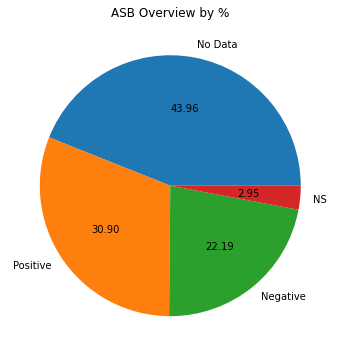

In [69]:
final['FINAL RESULTS'].value_counts().plot(kind='pie',
                                          labels=['No Data', 'Positive', 'Negative', 'NS'],
                                          autopct='%.2f',
                                          fontsize=10,
                                          figsize=(6,6),
                                          title='ASB Overview by %',
                                          ylabel="")

<AxesSubplot:title={'center':'Smart Sheets Overview by %'}>

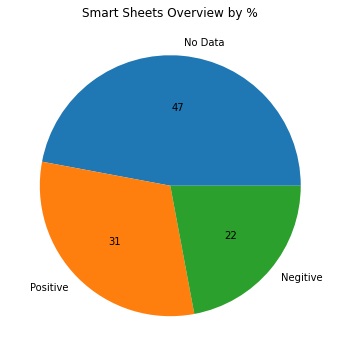

In [71]:
final['ASB RESULTS'].value_counts().plot(kind='pie',
                                       ylabel="",
                                       title="Smart Sheets Overview by %",
                                       autopct='%2.f',
                                       labels=['No Data', 'Positive', 'Negitive'],
                                       fontsize=10,
                                       figsize=(6,6))